source: 
- https://www.kaggle.com/immvab/transformers-covid-19-tweets-sentiment-analysis/comments
- https://www.kaggle.com/mehmetlaudatekman/text-classification-svm-explained
- https://www.kaggle.com/jackttai/coronavirus-tweets-nlp-using-logistic-regression
- https://nbviewer.jupyter.org/github/reetu95/DonorsChoose.org---LogisticRegression/blob/master/Logisticregression_donors.ipynb

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re
from bs4 import BeautifulSoup

pd.options.mode.chained_assignment = None

In [2]:
# read dataset

train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

In [3]:
# first five rows of train data
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
# first five rows of test data
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
# Check missing data at train set
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
# Check missing data at test set
test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [7]:
# concat partial data from two dataset 
df = pd.concat([train[:7000], test[:3000]])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
2995,2996,47948,"Atlanta, GA",15-03-2020,.@Amazon says it is out of #stock of #househol...,Negative
2996,2997,47949,Texas,15-03-2020,good job everyone..west texas supermarkets are...,Positive
2997,2998,47950,United States,15-03-2020,Stop #frenzybuying. You don't need most of wha...,Extremely Negative
2998,2999,47951,"California, USA",15-03-2020,https://t.co/L146FfLxQD \r\r\n\r\r\nI know a m...,Extremely Negative


In [8]:
# remove unwantesd features
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]
df.drop(unrelevant_features,inplace=True,axis=1)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
2995,.@Amazon says it is out of #stock of #househol...,Negative
2996,good job everyone..west texas supermarkets are...,Positive
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative
2998,https://t.co/L146FfLxQD \r\r\n\r\r\nI know a m...,Extremely Negative


#### EDA ( Exploratory Data Analysis)

In [9]:
# types of classifications
df["Sentiment"].value_counts()

Negative              2636
Positive              2610
Neutral               1713
Extremely Negative    1541
Extremely Positive    1500
Name: Sentiment, dtype: int64

Text(0, 0.5, 'Number of tweets')

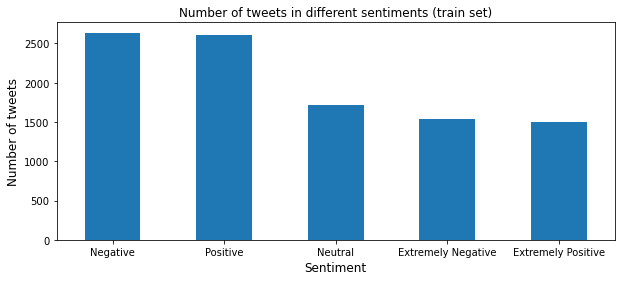

In [10]:
df.Sentiment.value_counts().plot.bar(figsize=(10,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments (train set)',fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)

In [11]:
# extremely positive -> positvive
# extremely negative -> negative
df['Sentiment'] = df.Sentiment.str.replace('Extremely Positive', 'Positive')
df['Sentiment'] = df.Sentiment.str.replace('Extremely Negative', 'Negative')

Negative    4177
Positive    4110
Neutral     1713
Name: Sentiment, dtype: int64


Text(0, 0.5, 'Number of tweets')

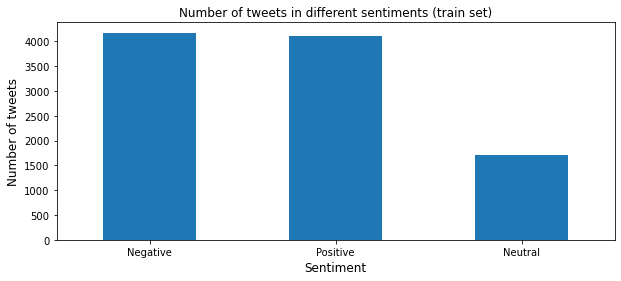

In [12]:
print(df["Sentiment"].value_counts())

df.Sentiment.value_counts().plot.bar(figsize=(10,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments (train set)',fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)

In [13]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative


In [14]:
# Map the sentiment into 0 , 1, 2
df['Sentiment'] = df['Sentiment'].map({'Positive':2, 'Negative':0, 'Neutral':1})

In [15]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,advice Talk to your neighbours family to excha...,2
2,Coronavirus Australia: Woolworths to give elde...,2
3,My food stock is not the only one which is emp...,2
4,"Me, ready to go at supermarket during the #COV...",0


##### Negative tweets wordcloud

In [16]:
neg_tweets = df[df.Sentiment == 0]
neg_string = []
for t in neg_tweets.OriginalTweet:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

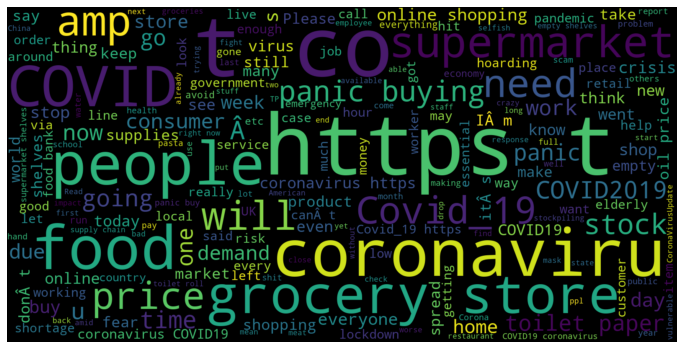

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Positive tweets wordcloud

In [18]:
pos_tweets = df[df.Sentiment == 2]
pos_string = []
for t in pos_tweets.OriginalTweet:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

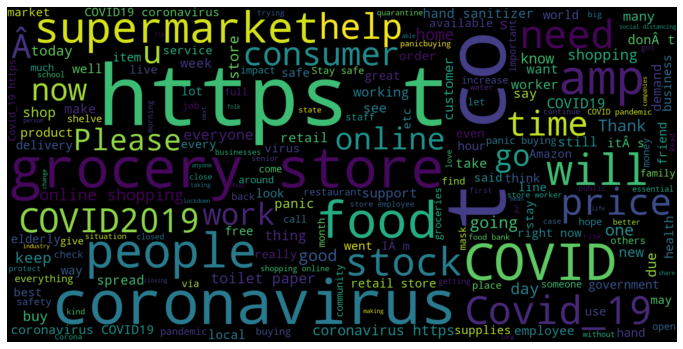

In [19]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From the wordcloud above, we can observe that there are noises in the tweets, pre-processing is needed

In [20]:
del train
del test

In [21]:
del neg_string
del neg_tweets
del pos_string
del pos_tweets

#### Data Pre-Processing

In [22]:
cleanedData = []
def clean_data(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    lemma = WordNetLemmatizer()
    swords = stopwords.words("english")
    
    text = re.sub(r'@\w+', '', text) #Remove mentions 
    text=re.sub(r'#\w+', '', text) #Remove hashtags

    # Cleaning links
    text = re.sub(r'http\S+', '', text)

    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z]"," ",text)

    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]

    # Removing stopwords
    text = [word for word in text if word not in swords]

    # Joining the tokens
    text = " ".join(text)

    cleanedData.append(text)
    return text

In [23]:
%%time

df['text']=df['OriginalTweet'].apply(lambda x:clean_data(x))
df

Wall time: 15 s


,OriginalTweet,Sentiment,text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,
1,advice Talk to your neighbours family to excha...,2,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,2,food stock one empty please panic enough food ...
4,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...
...,...,...,...
2995,.@Amazon says it is out of #stock of #househol...,0,say item delayed due demand amzn
2996,good job everyone..west texas supermarkets are...,2,good job everyone west texas supermarket stock...
2997,Stop #frenzybuying. You don't need most of wha...,0,stop need hoarding proof norm first selfishnes...
2998,https://t.co/L146FfLxQD \r\r\n\r\r\nI know a m...,0,know manager sam club say people increasingly ...


##### Negative tweets after pre-processing

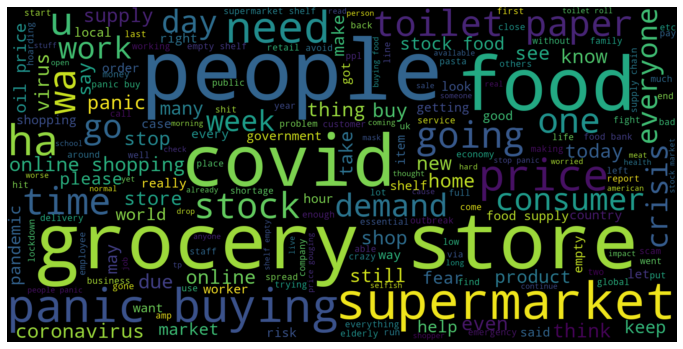

In [24]:
neg_tweets = df[df.Sentiment == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Positive tweets after pre-processing

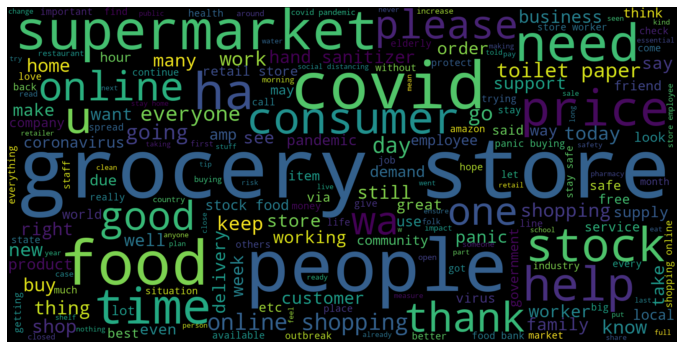

In [25]:
neg_tweets = df[df.Sentiment == 2]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Split data
- 90% Test <br>
- 10% Train <br>
- Train data here also known as hold-out set <br>
- Grid search cross-validation will be perform on selected model with train data <br>
- Choose best hyperparameter and evaluate on hold-out set

In [26]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(df['text'], df['Sentiment'], test_size=.10, random_state=42)

In [27]:
print(x_train.shape)
print(x_test.shape)

(9000,)
(1000,)


#### Word Embedding (BOW)
**Note: Data Leakage**<br>
- There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.<br>
- To avoid the issue of data-leakage, make sure to split your data first and then vectorize it.<br>
- While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.<br>

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=12000) #take 10k most common words only
X_train_bow = vect.fit_transform(x_train)

In [74]:
x_test_bow = vect.transform(x_test)
print(X_train_bow.shape)
print(x_test_bow.shape) #(row, no. of words)

(9000, 12000)
(1000, 12000)


#### Model Selection

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    SVC(),
    MultinomialNB(),
    LogisticRegression(max_iter=12000)
]

# 5 fold Cross-validation
kf = KFold(n_splits = 5)

entries = []
for model in models:
    print("Trying Model ", model)
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_bow, y_train, scoring='accuracy', cv=kf).mean()*100
    #for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, accuracies))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

In [76]:
cv_df

,model_name,accuracy
0,RandomForestClassifier,59.311111
1,SVC,70.166667
2,MultinomialNB,64.622222
3,LogisticRegression,73.388889


##### Why we use cross vaidation?
- Because model performance is dependent on way the data is split <br>
- Not representative of the model's ability to generalize unseen data

#### Hyperparameter Tuning

source: https://www.kaggle.com/crawford/hyperparameter-search-comparison-grid-vs-random

- logistic regression also has a regularization parameter: **C**. <br> 
- **C** controls the inverse of the regularization strength. <br> 
- A large **C** can lead to an overfit model, while a small **C** can lead to an underfit model. <br>
- use GridSearchCV and logistic regression to find the optimal **C** in this hyperparameter space

GridSearchCV can be seen of an extension of applying just a K-Fold, which is the way to go in the case of wanting to perform a hyper-parameter search over a predefined grid of parameters.

In [67]:
%%time 
# Grid Search for tuning parameters
from sklearn.model_selection import GridSearchCV
# RandomizedSearch for tuning (possibly faster than GridSearch)


logreg = LogisticRegression(max_iter=10000)

c_space = np.linspace(0.001,1,100)
param_grid = [
    {'C': c_space, 'penalty': ['l1'], 'solver': ['liblinear']},
    {'C': c_space, 'penalty': ['l2'], 'solver': ['lbfgs']}
 ]
#param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

#pipeline = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=10000))

grid = GridSearchCV(logreg, param_grid, cv=10, verbose=10)
grid.fit(X_train_bow, y_train)
print("Tuned LR accuracy: ", grid.score(x_test_bow, y_test))

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.420, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.420, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.420, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.420, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.419, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.419, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.419, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.419, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.419, total=   0.0s
[CV] C=0.001, penalty=l1, solver=liblinear ...........................
[CV]  C=0.001, penalty=l1, solver=liblinear, score=0.419, total=   0.0s
[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.496, total=   0.1s
[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.469, total=   0.1s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.483, total=   0.1s
[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.492, total=   0.1s
[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.502, total=   0.1s
[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.497, total=   0.1s
[CV] C=0.011090909090909092, penalty=l1, solver=liblinear ............
[CV]  C=0.011090909090909092, penalty=l1, solver=liblinear, score=0.511, total=   0.1s
[CV] C=0.011090909090909092, penalty=l1, solver=libl

[CV]  C=0.06154545454545455, penalty=l1, solver=liblinear, score=0.622, total=   0.1s
[CV] C=0.06154545454545455, penalty=l1, solver=liblinear .............
[CV]  C=0.06154545454545455, penalty=l1, solver=liblinear, score=0.610, total=   0.1s
[CV] C=0.06154545454545455, penalty=l1, solver=liblinear .............
[CV]  C=0.06154545454545455, penalty=l1, solver=liblinear, score=0.603, total=   0.1s
[CV] C=0.06154545454545455, penalty=l1, solver=liblinear .............
[CV]  C=0.06154545454545455, penalty=l1, solver=liblinear, score=0.606, total=   0.1s
[CV] C=0.06154545454545455, penalty=l1, solver=liblinear .............
[CV]  C=0.06154545454545455, penalty=l1, solver=liblinear, score=0.601, total=   0.1s
[CV] C=0.06154545454545455, penalty=l1, solver=liblinear .............
[CV]  C=0.06154545454545455, penalty=l1, solver=liblinear, score=0.610, total=   0.1s
[CV] C=0.07163636363636364, penalty=l1, solver=liblinear .............
[CV]  C=0.07163636363636364, penalty=l1, solver=liblinear,

[CV]  C=0.112, penalty=l1, solver=liblinear, score=0.668, total=   0.1s
[CV] C=0.112, penalty=l1, solver=liblinear ...........................
[CV]  C=0.112, penalty=l1, solver=liblinear, score=0.683, total=   0.1s
[CV] C=0.1220909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.1220909090909091, penalty=l1, solver=liblinear, score=0.664, total=   0.1s
[CV] C=0.1220909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.1220909090909091, penalty=l1, solver=liblinear, score=0.673, total=   0.1s
[CV] C=0.1220909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.1220909090909091, penalty=l1, solver=liblinear, score=0.647, total=   0.1s
[CV] C=0.1220909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.1220909090909091, penalty=l1, solver=liblinear, score=0.669, total=   0.1s
[CV] C=0.1220909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.1220909090909091, penalty=l1, solver=liblinear, score=0.682, total=   0.1s
[CV] 

[CV]  C=0.17254545454545456, penalty=l1, solver=liblinear, score=0.678, total=   0.1s
[CV] C=0.17254545454545456, penalty=l1, solver=liblinear .............
[CV]  C=0.17254545454545456, penalty=l1, solver=liblinear, score=0.703, total=   0.1s
[CV] C=0.17254545454545456, penalty=l1, solver=liblinear .............
[CV]  C=0.17254545454545456, penalty=l1, solver=liblinear, score=0.704, total=   0.1s
[CV] C=0.17254545454545456, penalty=l1, solver=liblinear .............
[CV]  C=0.17254545454545456, penalty=l1, solver=liblinear, score=0.723, total=   0.1s
[CV] C=0.17254545454545456, penalty=l1, solver=liblinear .............
[CV]  C=0.17254545454545456, penalty=l1, solver=liblinear, score=0.704, total=   0.1s
[CV] C=0.17254545454545456, penalty=l1, solver=liblinear .............
[CV]  C=0.17254545454545456, penalty=l1, solver=liblinear, score=0.693, total=   0.1s
[CV] C=0.17254545454545456, penalty=l1, solver=liblinear .............
[CV]  C=0.17254545454545456, penalty=l1, solver=liblinear,

[CV]  C=0.223, penalty=l1, solver=liblinear, score=0.722, total=   0.1s
[CV] C=0.223, penalty=l1, solver=liblinear ...........................
[CV]  C=0.223, penalty=l1, solver=liblinear, score=0.709, total=   0.1s
[CV] C=0.223, penalty=l1, solver=liblinear ...........................
[CV]  C=0.223, penalty=l1, solver=liblinear, score=0.716, total=   0.1s
[CV] C=0.223, penalty=l1, solver=liblinear ...........................
[CV]  C=0.223, penalty=l1, solver=liblinear, score=0.748, total=   0.1s
[CV] C=0.2330909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.2330909090909091, penalty=l1, solver=liblinear, score=0.738, total=   0.1s
[CV] C=0.2330909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.2330909090909091, penalty=l1, solver=liblinear, score=0.723, total=   0.1s
[CV] C=0.2330909090909091, penalty=l1, solver=liblinear ..............
[CV]  C=0.2330909090909091, penalty=l1, solver=liblinear, score=0.712, total=   0.1s
[CV] C=0.2330909090909091, pena

[CV]  C=0.27345454545454545, penalty=l1, solver=liblinear, score=0.752, total=   0.1s
[CV] C=0.28354545454545454, penalty=l1, solver=liblinear .............
[CV]  C=0.28354545454545454, penalty=l1, solver=liblinear, score=0.752, total=   0.1s
[CV] C=0.28354545454545454, penalty=l1, solver=liblinear .............
[CV]  C=0.28354545454545454, penalty=l1, solver=liblinear, score=0.736, total=   0.1s
[CV] C=0.28354545454545454, penalty=l1, solver=liblinear .............
[CV]  C=0.28354545454545454, penalty=l1, solver=liblinear, score=0.729, total=   0.1s
[CV] C=0.28354545454545454, penalty=l1, solver=liblinear .............
[CV]  C=0.28354545454545454, penalty=l1, solver=liblinear, score=0.747, total=   0.1s
[CV] C=0.28354545454545454, penalty=l1, solver=liblinear .............
[CV]  C=0.28354545454545454, penalty=l1, solver=liblinear, score=0.740, total=   0.1s
[CV] C=0.28354545454545454, penalty=l1, solver=liblinear .............
[CV]  C=0.28354545454545454, penalty=l1, solver=liblinear,

[CV]  C=0.334, penalty=l1, solver=liblinear, score=0.754, total=   0.1s
[CV] C=0.334, penalty=l1, solver=liblinear ...........................
[CV]  C=0.334, penalty=l1, solver=liblinear, score=0.744, total=   0.1s
[CV] C=0.334, penalty=l1, solver=liblinear ...........................
[CV]  C=0.334, penalty=l1, solver=liblinear, score=0.774, total=   0.1s
[CV] C=0.334, penalty=l1, solver=liblinear ...........................
[CV]  C=0.334, penalty=l1, solver=liblinear, score=0.731, total=   0.1s
[CV] C=0.334, penalty=l1, solver=liblinear ...........................
[CV]  C=0.334, penalty=l1, solver=liblinear, score=0.746, total=   0.1s
[CV] C=0.334, penalty=l1, solver=liblinear ...........................
[CV]  C=0.334, penalty=l1, solver=liblinear, score=0.740, total=   0.1s
[CV] C=0.334, penalty=l1, solver=liblinear ...........................
[CV]  C=0.334, penalty=l1, solver=liblinear, score=0.756, total=   0.1s
[CV] C=0.3440909090909091, penalty=l1, solver=liblinear ..............

[CV]  C=0.3844545454545455, penalty=l1, solver=liblinear, score=0.753, total=   0.1s
[CV] C=0.3844545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.3844545454545455, penalty=l1, solver=liblinear, score=0.748, total=   0.1s
[CV] C=0.3844545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.3844545454545455, penalty=l1, solver=liblinear, score=0.757, total=   0.1s
[CV] C=0.3945454545454546, penalty=l1, solver=liblinear ..............
[CV]  C=0.3945454545454546, penalty=l1, solver=liblinear, score=0.768, total=   0.1s
[CV] C=0.3945454545454546, penalty=l1, solver=liblinear ..............
[CV]  C=0.3945454545454546, penalty=l1, solver=liblinear, score=0.746, total=   0.1s
[CV] C=0.3945454545454546, penalty=l1, solver=liblinear ..............
[CV]  C=0.3945454545454546, penalty=l1, solver=liblinear, score=0.736, total=   0.1s
[CV] C=0.3945454545454546, penalty=l1, solver=liblinear ..............
[CV]  C=0.3945454545454546, penalty=l1, solver=liblinear, score=

[CV]  C=0.445, penalty=l1, solver=liblinear, score=0.749, total=   0.1s
[CV] C=0.445, penalty=l1, solver=liblinear ...........................
[CV]  C=0.445, penalty=l1, solver=liblinear, score=0.741, total=   0.1s
[CV] C=0.445, penalty=l1, solver=liblinear ...........................
[CV]  C=0.445, penalty=l1, solver=liblinear, score=0.757, total=   0.1s
[CV] C=0.445, penalty=l1, solver=liblinear ...........................
[CV]  C=0.445, penalty=l1, solver=liblinear, score=0.754, total=   0.1s
[CV] C=0.445, penalty=l1, solver=liblinear ...........................
[CV]  C=0.445, penalty=l1, solver=liblinear, score=0.783, total=   0.1s
[CV] C=0.445, penalty=l1, solver=liblinear ...........................
[CV]  C=0.445, penalty=l1, solver=liblinear, score=0.758, total=   0.1s
[CV] C=0.445, penalty=l1, solver=liblinear ...........................
[CV]  C=0.445, penalty=l1, solver=liblinear, score=0.762, total=   0.1s
[CV] C=0.445, penalty=l1, solver=liblinear ...........................

[CV]  C=0.4954545454545455, penalty=l1, solver=liblinear, score=0.792, total=   0.1s
[CV] C=0.4954545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.4954545454545455, penalty=l1, solver=liblinear, score=0.756, total=   0.1s
[CV] C=0.4954545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.4954545454545455, penalty=l1, solver=liblinear, score=0.770, total=   0.1s
[CV] C=0.4954545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.4954545454545455, penalty=l1, solver=liblinear, score=0.759, total=   0.1s
[CV] C=0.4954545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.4954545454545455, penalty=l1, solver=liblinear, score=0.764, total=   0.1s
[CV] C=0.5055454545454545, penalty=l1, solver=liblinear ..............
[CV]  C=0.5055454545454545, penalty=l1, solver=liblinear, score=0.783, total=   0.1s
[CV] C=0.5055454545454545, penalty=l1, solver=liblinear ..............
[CV]  C=0.5055454545454545, penalty=l1, solver=liblinear, score=

[CV]  C=0.5459090909090909, penalty=l1, solver=liblinear, score=0.766, total=   0.1s
[CV] C=0.556, penalty=l1, solver=liblinear ...........................
[CV]  C=0.556, penalty=l1, solver=liblinear, score=0.787, total=   0.1s
[CV] C=0.556, penalty=l1, solver=liblinear ...........................
[CV]  C=0.556, penalty=l1, solver=liblinear, score=0.756, total=   0.1s
[CV] C=0.556, penalty=l1, solver=liblinear ...........................
[CV]  C=0.556, penalty=l1, solver=liblinear, score=0.759, total=   0.1s
[CV] C=0.556, penalty=l1, solver=liblinear ...........................
[CV]  C=0.556, penalty=l1, solver=liblinear, score=0.767, total=   0.1s
[CV] C=0.556, penalty=l1, solver=liblinear ...........................
[CV]  C=0.556, penalty=l1, solver=liblinear, score=0.766, total=   0.1s
[CV] C=0.556, penalty=l1, solver=liblinear ...........................
[CV]  C=0.556, penalty=l1, solver=liblinear, score=0.792, total=   0.1s
[CV] C=0.556, penalty=l1, solver=liblinear ..............

[CV]  C=0.6064545454545455, penalty=l1, solver=liblinear, score=0.766, total=   0.1s
[CV] C=0.6064545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.6064545454545455, penalty=l1, solver=liblinear, score=0.762, total=   0.1s
[CV] C=0.6064545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.6064545454545455, penalty=l1, solver=liblinear, score=0.793, total=   0.1s
[CV] C=0.6064545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.6064545454545455, penalty=l1, solver=liblinear, score=0.760, total=   0.1s
[CV] C=0.6064545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.6064545454545455, penalty=l1, solver=liblinear, score=0.774, total=   0.1s
[CV] C=0.6064545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.6064545454545455, penalty=l1, solver=liblinear, score=0.762, total=   0.1s
[CV] C=0.6064545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.6064545454545455, penalty=l1, solver=liblinear, score=

[CV]  C=0.6569090909090909, penalty=l1, solver=liblinear, score=0.778, total=   0.1s
[CV] C=0.6569090909090909, penalty=l1, solver=liblinear ..............
[CV]  C=0.6569090909090909, penalty=l1, solver=liblinear, score=0.761, total=   0.1s
[CV] C=0.6569090909090909, penalty=l1, solver=liblinear ..............
[CV]  C=0.6569090909090909, penalty=l1, solver=liblinear, score=0.769, total=   0.1s
[CV] C=0.667, penalty=l1, solver=liblinear ...........................
[CV]  C=0.667, penalty=l1, solver=liblinear, score=0.792, total=   0.1s
[CV] C=0.667, penalty=l1, solver=liblinear ...........................
[CV]  C=0.667, penalty=l1, solver=liblinear, score=0.764, total=   0.1s
[CV] C=0.667, penalty=l1, solver=liblinear ...........................
[CV]  C=0.667, penalty=l1, solver=liblinear, score=0.762, total=   0.1s
[CV] C=0.667, penalty=l1, solver=liblinear ...........................
[CV]  C=0.667, penalty=l1, solver=liblinear, score=0.769, total=   0.1s
[CV] C=0.667, penalty=l1, solve

[CV]  C=0.7174545454545455, penalty=l1, solver=liblinear, score=0.764, total=   0.1s
[CV] C=0.7174545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.7174545454545455, penalty=l1, solver=liblinear, score=0.763, total=   0.1s
[CV] C=0.7174545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.7174545454545455, penalty=l1, solver=liblinear, score=0.771, total=   0.1s
[CV] C=0.7174545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.7174545454545455, penalty=l1, solver=liblinear, score=0.760, total=   0.1s
[CV] C=0.7174545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.7174545454545455, penalty=l1, solver=liblinear, score=0.800, total=   0.1s
[CV] C=0.7174545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.7174545454545455, penalty=l1, solver=liblinear, score=0.768, total=   0.1s
[CV] C=0.7174545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.7174545454545455, penalty=l1, solver=liblinear, score=

[CV]  C=0.767909090909091, penalty=l1, solver=liblinear, score=0.797, total=   0.1s
[CV] C=0.767909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.767909090909091, penalty=l1, solver=liblinear, score=0.770, total=   0.1s
[CV] C=0.767909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.767909090909091, penalty=l1, solver=liblinear, score=0.781, total=   0.1s
[CV] C=0.767909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.767909090909091, penalty=l1, solver=liblinear, score=0.764, total=   0.1s
[CV] C=0.767909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.767909090909091, penalty=l1, solver=liblinear, score=0.776, total=   0.1s
[CV] C=0.778, penalty=l1, solver=liblinear ...........................
[CV]  C=0.778, penalty=l1, solver=liblinear, score=0.792, total=   0.1s
[CV] C=0.778, penalty=l1, solver=liblinear ...........................
[CV]  C=0.778, penalty=l1, solver=liblinear, score=0.764, total=   0.1s
[CV] C=0.7

[CV]  C=0.8183636363636364, penalty=l1, solver=liblinear, score=0.776, total=   0.1s
[CV] C=0.8284545454545454, penalty=l1, solver=liblinear ..............
[CV]  C=0.8284545454545454, penalty=l1, solver=liblinear, score=0.797, total=   0.1s
[CV] C=0.8284545454545454, penalty=l1, solver=liblinear ..............
[CV]  C=0.8284545454545454, penalty=l1, solver=liblinear, score=0.764, total=   0.1s
[CV] C=0.8284545454545454, penalty=l1, solver=liblinear ..............
[CV]  C=0.8284545454545454, penalty=l1, solver=liblinear, score=0.769, total=   0.1s
[CV] C=0.8284545454545454, penalty=l1, solver=liblinear ..............
[CV]  C=0.8284545454545454, penalty=l1, solver=liblinear, score=0.770, total=   0.1s
[CV] C=0.8284545454545454, penalty=l1, solver=liblinear ..............
[CV]  C=0.8284545454545454, penalty=l1, solver=liblinear, score=0.764, total=   0.1s
[CV] C=0.8284545454545454, penalty=l1, solver=liblinear ..............
[CV]  C=0.8284545454545454, penalty=l1, solver=liblinear, score=

[CV]  C=0.878909090909091, penalty=l1, solver=liblinear, score=0.769, total=   0.1s
[CV] C=0.878909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.878909090909091, penalty=l1, solver=liblinear, score=0.768, total=   0.1s
[CV] C=0.878909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.878909090909091, penalty=l1, solver=liblinear, score=0.796, total=   0.1s
[CV] C=0.878909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.878909090909091, penalty=l1, solver=liblinear, score=0.771, total=   0.1s
[CV] C=0.878909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.878909090909091, penalty=l1, solver=liblinear, score=0.781, total=   0.2s
[CV] C=0.878909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.878909090909091, penalty=l1, solver=liblinear, score=0.770, total=   0.1s
[CV] C=0.878909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.878909090909091, penalty=l1, solver=liblinear, score=0.770, 

[CV]  C=0.9293636363636364, penalty=l1, solver=liblinear, score=0.781, total=   0.1s
[CV] C=0.9293636363636364, penalty=l1, solver=liblinear ..............
[CV]  C=0.9293636363636364, penalty=l1, solver=liblinear, score=0.768, total=   0.1s
[CV] C=0.9293636363636364, penalty=l1, solver=liblinear ..............
[CV]  C=0.9293636363636364, penalty=l1, solver=liblinear, score=0.773, total=   0.1s
[CV] C=0.9394545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.9394545454545455, penalty=l1, solver=liblinear, score=0.794, total=   0.1s
[CV] C=0.9394545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.9394545454545455, penalty=l1, solver=liblinear, score=0.761, total=   0.1s
[CV] C=0.9394545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.9394545454545455, penalty=l1, solver=liblinear, score=0.778, total=   0.1s
[CV] C=0.9394545454545455, penalty=l1, solver=liblinear ..............
[CV]  C=0.9394545454545455, penalty=l1, solver=liblinear, score=

[CV]  C=0.989909090909091, penalty=l1, solver=liblinear, score=0.758, total=   0.1s
[CV] C=0.989909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.989909090909091, penalty=l1, solver=liblinear, score=0.776, total=   0.1s
[CV] C=0.989909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.989909090909091, penalty=l1, solver=liblinear, score=0.773, total=   0.1s
[CV] C=0.989909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.989909090909091, penalty=l1, solver=liblinear, score=0.768, total=   0.1s
[CV] C=0.989909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.989909090909091, penalty=l1, solver=liblinear, score=0.798, total=   0.2s
[CV] C=0.989909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.989909090909091, penalty=l1, solver=liblinear, score=0.771, total=   0.1s
[CV] C=0.989909090909091, penalty=l1, solver=liblinear ...............
[CV]  C=0.989909090909091, penalty=l1, solver=liblinear, score=0.782, 

[CV]  C=0.03127272727272727, penalty=l2, solver=lbfgs, score=0.701, total=   0.4s
[CV] C=0.03127272727272727, penalty=l2, solver=lbfgs .................
[CV]  C=0.03127272727272727, penalty=l2, solver=lbfgs, score=0.674, total=   0.4s
[CV] C=0.03127272727272727, penalty=l2, solver=lbfgs .................
[CV]  C=0.03127272727272727, penalty=l2, solver=lbfgs, score=0.699, total=   0.5s
[CV] C=0.03127272727272727, penalty=l2, solver=lbfgs .................
[CV]  C=0.03127272727272727, penalty=l2, solver=lbfgs, score=0.724, total=   0.4s
[CV] C=0.041363636363636366, penalty=l2, solver=lbfgs ................
[CV]  C=0.041363636363636366, penalty=l2, solver=lbfgs, score=0.724, total=   0.4s
[CV] C=0.041363636363636366, penalty=l2, solver=lbfgs ................
[CV]  C=0.041363636363636366, penalty=l2, solver=lbfgs, score=0.731, total=   0.5s
[CV] C=0.041363636363636366, penalty=l2, solver=lbfgs ................
[CV]  C=0.041363636363636366, penalty=l2, solver=lbfgs, score=0.691, total=   0.

[CV]  C=0.09181818181818183, penalty=l2, solver=lbfgs, score=0.752, total=   0.7s
[CV] C=0.09181818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.09181818181818183, penalty=l2, solver=lbfgs, score=0.737, total=   0.7s
[CV] C=0.09181818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.09181818181818183, penalty=l2, solver=lbfgs, score=0.708, total=   0.7s
[CV] C=0.09181818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.09181818181818183, penalty=l2, solver=lbfgs, score=0.739, total=   0.7s
[CV] C=0.09181818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.09181818181818183, penalty=l2, solver=lbfgs, score=0.739, total=   0.6s
[CV] C=0.09181818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.09181818181818183, penalty=l2, solver=lbfgs, score=0.748, total=   0.7s
[CV] C=0.09181818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.09181818181818183, penalty=l2, solver=lbfgs, score=0.724, total=   0.7s


[CV]  C=0.14227272727272727, penalty=l2, solver=lbfgs, score=0.766, total=   0.8s
[CV] C=0.14227272727272727, penalty=l2, solver=lbfgs .................
[CV]  C=0.14227272727272727, penalty=l2, solver=lbfgs, score=0.732, total=   0.8s
[CV] C=0.14227272727272727, penalty=l2, solver=lbfgs .................
[CV]  C=0.14227272727272727, penalty=l2, solver=lbfgs, score=0.724, total=   0.8s
[CV] C=0.14227272727272727, penalty=l2, solver=lbfgs .................
[CV]  C=0.14227272727272727, penalty=l2, solver=lbfgs, score=0.749, total=   0.8s
[CV] C=0.14227272727272727, penalty=l2, solver=lbfgs .................
[CV]  C=0.14227272727272727, penalty=l2, solver=lbfgs, score=0.760, total=   0.8s
[CV] C=0.15236363636363637, penalty=l2, solver=lbfgs .................
[CV]  C=0.15236363636363637, penalty=l2, solver=lbfgs, score=0.754, total=   0.8s
[CV] C=0.15236363636363637, penalty=l2, solver=lbfgs .................
[CV]  C=0.15236363636363637, penalty=l2, solver=lbfgs, score=0.742, total=   0.7s


[CV]  C=0.19272727272727275, penalty=l2, solver=lbfgs, score=0.761, total=   0.9s
[CV] C=0.20281818181818184, penalty=l2, solver=lbfgs .................
[CV]  C=0.20281818181818184, penalty=l2, solver=lbfgs, score=0.757, total=   0.9s
[CV] C=0.20281818181818184, penalty=l2, solver=lbfgs .................
[CV]  C=0.20281818181818184, penalty=l2, solver=lbfgs, score=0.742, total=   0.9s
[CV] C=0.20281818181818184, penalty=l2, solver=lbfgs .................
[CV]  C=0.20281818181818184, penalty=l2, solver=lbfgs, score=0.720, total=   0.9s
[CV] C=0.20281818181818184, penalty=l2, solver=lbfgs .................
[CV]  C=0.20281818181818184, penalty=l2, solver=lbfgs, score=0.748, total=   1.0s
[CV] C=0.20281818181818184, penalty=l2, solver=lbfgs .................
[CV]  C=0.20281818181818184, penalty=l2, solver=lbfgs, score=0.751, total=   0.9s
[CV] C=0.20281818181818184, penalty=l2, solver=lbfgs .................
[CV]  C=0.20281818181818184, penalty=l2, solver=lbfgs, score=0.766, total=   0.9s


[CV]  C=0.25327272727272726, penalty=l2, solver=lbfgs, score=0.754, total=   0.9s
[CV] C=0.25327272727272726, penalty=l2, solver=lbfgs .................
[CV]  C=0.25327272727272726, penalty=l2, solver=lbfgs, score=0.762, total=   1.0s
[CV] C=0.25327272727272726, penalty=l2, solver=lbfgs .................
[CV]  C=0.25327272727272726, penalty=l2, solver=lbfgs, score=0.737, total=   1.0s
[CV] C=0.25327272727272726, penalty=l2, solver=lbfgs .................
[CV]  C=0.25327272727272726, penalty=l2, solver=lbfgs, score=0.739, total=   1.0s
[CV] C=0.25327272727272726, penalty=l2, solver=lbfgs .................
[CV]  C=0.25327272727272726, penalty=l2, solver=lbfgs, score=0.751, total=   0.9s
[CV] C=0.25327272727272726, penalty=l2, solver=lbfgs .................
[CV]  C=0.25327272727272726, penalty=l2, solver=lbfgs, score=0.757, total=   0.9s
[CV] C=0.26336363636363636, penalty=l2, solver=lbfgs .................
[CV]  C=0.26336363636363636, penalty=l2, solver=lbfgs, score=0.757, total=   0.9s


[CV]  C=0.30372727272727273, penalty=l2, solver=lbfgs, score=0.750, total=   1.1s
[CV] C=0.30372727272727273, penalty=l2, solver=lbfgs .................
[CV]  C=0.30372727272727273, penalty=l2, solver=lbfgs, score=0.757, total=   1.1s
[CV] C=0.31381818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.31381818181818183, penalty=l2, solver=lbfgs, score=0.754, total=   1.1s
[CV] C=0.31381818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.31381818181818183, penalty=l2, solver=lbfgs, score=0.738, total=   1.0s
[CV] C=0.31381818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.31381818181818183, penalty=l2, solver=lbfgs, score=0.724, total=   1.0s
[CV] C=0.31381818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.31381818181818183, penalty=l2, solver=lbfgs, score=0.756, total=   1.1s
[CV] C=0.31381818181818183, penalty=l2, solver=lbfgs .................
[CV]  C=0.31381818181818183, penalty=l2, solver=lbfgs, score=0.758, total=   1.1s


[CV]  C=0.3642727272727273, penalty=l2, solver=lbfgs, score=0.754, total=   1.0s
[CV] C=0.3642727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.3642727272727273, penalty=l2, solver=lbfgs, score=0.753, total=   1.1s
[CV] C=0.3642727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.3642727272727273, penalty=l2, solver=lbfgs, score=0.761, total=   1.1s
[CV] C=0.3642727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.3642727272727273, penalty=l2, solver=lbfgs, score=0.740, total=   1.1s
[CV] C=0.3642727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.3642727272727273, penalty=l2, solver=lbfgs, score=0.748, total=   1.1s
[CV] C=0.3642727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.3642727272727273, penalty=l2, solver=lbfgs, score=0.751, total=   1.1s
[CV] C=0.3642727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.3642727272727273, penalty=l2, solver=lbfgs, score=0.754, total=   1.1s
[CV] C=

[CV]  C=0.4147272727272727, penalty=l2, solver=lbfgs, score=0.748, total=   1.1s
[CV] C=0.4147272727272727, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4147272727272727, penalty=l2, solver=lbfgs, score=0.754, total=   1.2s
[CV] C=0.4147272727272727, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4147272727272727, penalty=l2, solver=lbfgs, score=0.750, total=   1.1s
[CV] C=0.4248181818181818, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4248181818181818, penalty=l2, solver=lbfgs, score=0.753, total=   1.2s
[CV] C=0.4248181818181818, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4248181818181818, penalty=l2, solver=lbfgs, score=0.741, total=   1.2s
[CV] C=0.4248181818181818, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4248181818181818, penalty=l2, solver=lbfgs, score=0.733, total=   1.1s
[CV] C=0.4248181818181818, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4248181818181818, penalty=l2, solver=lbfgs, score=0.756, total=   1.1s
[CV] C=

[CV]  C=0.4752727272727273, penalty=l2, solver=lbfgs, score=0.734, total=   1.2s
[CV] C=0.4752727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4752727272727273, penalty=l2, solver=lbfgs, score=0.751, total=   1.2s
[CV] C=0.4752727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4752727272727273, penalty=l2, solver=lbfgs, score=0.752, total=   1.2s
[CV] C=0.4752727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4752727272727273, penalty=l2, solver=lbfgs, score=0.766, total=   1.2s
[CV] C=0.4752727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4752727272727273, penalty=l2, solver=lbfgs, score=0.740, total=   1.1s
[CV] C=0.4752727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4752727272727273, penalty=l2, solver=lbfgs, score=0.748, total=   1.1s
[CV] C=0.4752727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.4752727272727273, penalty=l2, solver=lbfgs, score=0.753, total=   1.2s
[CV] C=

[CV]  C=0.5257272727272727, penalty=l2, solver=lbfgs, score=0.741, total=   1.1s
[CV] C=0.5257272727272727, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5257272727272727, penalty=l2, solver=lbfgs, score=0.747, total=   1.3s
[CV] C=0.5257272727272727, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5257272727272727, penalty=l2, solver=lbfgs, score=0.753, total=   1.4s
[CV] C=0.5257272727272727, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5257272727272727, penalty=l2, solver=lbfgs, score=0.749, total=   1.3s
[CV] C=0.5358181818181819, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5358181818181819, penalty=l2, solver=lbfgs, score=0.754, total=   1.2s
[CV] C=0.5358181818181819, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5358181818181819, penalty=l2, solver=lbfgs, score=0.741, total=   1.2s
[CV] C=0.5358181818181819, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5358181818181819, penalty=l2, solver=lbfgs, score=0.733, total=   1.2s
[CV] C=

[CV]  C=0.5862727272727273, penalty=l2, solver=lbfgs, score=0.741, total=   1.6s
[CV] C=0.5862727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5862727272727273, penalty=l2, solver=lbfgs, score=0.733, total=   1.3s
[CV] C=0.5862727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5862727272727273, penalty=l2, solver=lbfgs, score=0.748, total=   1.3s
[CV] C=0.5862727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5862727272727273, penalty=l2, solver=lbfgs, score=0.752, total=   1.3s
[CV] C=0.5862727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5862727272727273, penalty=l2, solver=lbfgs, score=0.766, total=   1.3s
[CV] C=0.5862727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5862727272727273, penalty=l2, solver=lbfgs, score=0.742, total=   1.3s
[CV] C=0.5862727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.5862727272727273, penalty=l2, solver=lbfgs, score=0.747, total=   1.3s
[CV] C=

[CV]  C=0.6367272727272728, penalty=l2, solver=lbfgs, score=0.767, total=   1.4s
[CV] C=0.6367272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6367272727272728, penalty=l2, solver=lbfgs, score=0.742, total=   1.3s
[CV] C=0.6367272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6367272727272728, penalty=l2, solver=lbfgs, score=0.747, total=   1.3s
[CV] C=0.6367272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6367272727272728, penalty=l2, solver=lbfgs, score=0.748, total=   1.3s
[CV] C=0.6367272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6367272727272728, penalty=l2, solver=lbfgs, score=0.749, total=   1.4s
[CV] C=0.6468181818181818, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6468181818181818, penalty=l2, solver=lbfgs, score=0.753, total=   1.3s
[CV] C=0.6468181818181818, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6468181818181818, penalty=l2, solver=lbfgs, score=0.741, total=   1.3s
[CV] C=

[CV]  C=0.6972727272727273, penalty=l2, solver=lbfgs, score=0.754, total=   1.4s
[CV] C=0.6972727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6972727272727273, penalty=l2, solver=lbfgs, score=0.736, total=   1.3s
[CV] C=0.6972727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6972727272727273, penalty=l2, solver=lbfgs, score=0.731, total=   1.4s
[CV] C=0.6972727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6972727272727273, penalty=l2, solver=lbfgs, score=0.743, total=   1.4s
[CV] C=0.6972727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6972727272727273, penalty=l2, solver=lbfgs, score=0.751, total=   1.4s
[CV] C=0.6972727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6972727272727273, penalty=l2, solver=lbfgs, score=0.764, total=   1.4s
[CV] C=0.6972727272727273, penalty=l2, solver=lbfgs ..................
[CV]  C=0.6972727272727273, penalty=l2, solver=lbfgs, score=0.742, total=   1.3s
[CV] C=

[CV]  C=0.7477272727272728, penalty=l2, solver=lbfgs, score=0.750, total=   1.4s
[CV] C=0.7477272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.7477272727272728, penalty=l2, solver=lbfgs, score=0.761, total=   1.4s
[CV] C=0.7477272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.7477272727272728, penalty=l2, solver=lbfgs, score=0.743, total=   1.3s
[CV] C=0.7477272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.7477272727272728, penalty=l2, solver=lbfgs, score=0.746, total=   1.4s
[CV] C=0.7477272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.7477272727272728, penalty=l2, solver=lbfgs, score=0.748, total=   1.4s
[CV] C=0.7477272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.7477272727272728, penalty=l2, solver=lbfgs, score=0.750, total=   1.5s
[CV] C=0.7578181818181818, penalty=l2, solver=lbfgs ..................
[CV]  C=0.7578181818181818, penalty=l2, solver=lbfgs, score=0.756, total=   1.6s
[CV] C=

[CV]  C=0.7981818181818182, penalty=l2, solver=lbfgs, score=0.746, total=   1.5s
[CV] C=0.8082727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8082727272727274, penalty=l2, solver=lbfgs, score=0.758, total=   1.5s
[CV] C=0.8082727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8082727272727274, penalty=l2, solver=lbfgs, score=0.736, total=   1.5s
[CV] C=0.8082727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8082727272727274, penalty=l2, solver=lbfgs, score=0.736, total=   1.4s
[CV] C=0.8082727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8082727272727274, penalty=l2, solver=lbfgs, score=0.739, total=   1.5s
[CV] C=0.8082727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8082727272727274, penalty=l2, solver=lbfgs, score=0.752, total=   1.5s
[CV] C=0.8082727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8082727272727274, penalty=l2, solver=lbfgs, score=0.760, total=   1.4s
[CV] C=

[CV]  C=0.8587272727272728, penalty=l2, solver=lbfgs, score=0.739, total=   1.6s
[CV] C=0.8587272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8587272727272728, penalty=l2, solver=lbfgs, score=0.750, total=   1.4s
[CV] C=0.8587272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8587272727272728, penalty=l2, solver=lbfgs, score=0.760, total=   1.5s
[CV] C=0.8587272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8587272727272728, penalty=l2, solver=lbfgs, score=0.744, total=   1.4s
[CV] C=0.8587272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8587272727272728, penalty=l2, solver=lbfgs, score=0.744, total=   1.4s
[CV] C=0.8587272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8587272727272728, penalty=l2, solver=lbfgs, score=0.747, total=   1.4s
[CV] C=0.8587272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.8587272727272728, penalty=l2, solver=lbfgs, score=0.746, total=   1.5s
[CV] C=

[CV]  C=0.9091818181818182, penalty=l2, solver=lbfgs, score=0.744, total=   1.5s
[CV] C=0.9091818181818182, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9091818181818182, penalty=l2, solver=lbfgs, score=0.743, total=   1.5s
[CV] C=0.9192727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9192727272727274, penalty=l2, solver=lbfgs, score=0.757, total=   1.5s
[CV] C=0.9192727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9192727272727274, penalty=l2, solver=lbfgs, score=0.733, total=   1.5s
[CV] C=0.9192727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9192727272727274, penalty=l2, solver=lbfgs, score=0.736, total=   1.4s
[CV] C=0.9192727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9192727272727274, penalty=l2, solver=lbfgs, score=0.741, total=   1.5s
[CV] C=0.9192727272727274, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9192727272727274, penalty=l2, solver=lbfgs, score=0.751, total=   1.4s
[CV] C=

[CV]  C=0.9697272727272728, penalty=l2, solver=lbfgs, score=0.734, total=   1.6s
[CV] C=0.9697272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9697272727272728, penalty=l2, solver=lbfgs, score=0.740, total=   1.6s
[CV] C=0.9697272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9697272727272728, penalty=l2, solver=lbfgs, score=0.752, total=   1.5s
[CV] C=0.9697272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9697272727272728, penalty=l2, solver=lbfgs, score=0.758, total=   1.6s
[CV] C=0.9697272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9697272727272728, penalty=l2, solver=lbfgs, score=0.746, total=   1.5s
[CV] C=0.9697272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9697272727272728, penalty=l2, solver=lbfgs, score=0.744, total=   1.4s
[CV] C=0.9697272727272728, penalty=l2, solver=lbfgs ..................
[CV]  C=0.9697272727272728, penalty=l2, solver=lbfgs, score=0.744, total=   1.4s
[CV] C=

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed: 21.4min finished


In [68]:
grid.best_params_

{'C': 0.8990909090909092, 'penalty': 'l1', 'solver': 'liblinear'}

In [69]:
logreg = LogisticRegression(**grid.best_params_)


logreg.fit(X_train_bow, y_train)
print ("train score: ", logreg.score(X_train_bow, y_train))
print("Tuned LR accuracy: ", logreg.score(x_test_bow, y_test))

train score:  0.9027777777777778
Tuned LR accuracy:  0.777
